# Extract data and related Evs distribution from TestAnEv Dataset 

The dataset is extracted from the Test-an-EV project [website](http://mclabprojects.di.uniroma1.it/smarthgnew/Test-an-EV/?EV-code=EV1) using [@sharyal's](fdfd) [script](../Modules/TestAnEvDataSet_DownloadingScript.py). A copy containing the files that we make use of are available in the subfolder [DataFiles/TestAnEvDataset](../DataFiles/TestAnEvDataset.zip). 


In [1]:
# Import Modules
import numpy as np,  pandas as pd, csv, random
import matplotlib.pyplot as plt
import sys,os
import scipy.stats
import seaborn as sbn
from scipy import signal, spatial, stats

# %jupyter matplotlib
%matplotlib inline
from tqdm import tqdm
from datetime import timedelta

In [2]:
# Funtions to use later

# Define my own Kolmogorov-Smirnov test based on the one from stats toolbox
def kstest(input_data, fit_distname, params):
    """
    Perform kolmogorov-smirnov goodness of fit test 
    
    Inputs:
    -------
    input_data:  1-D array
        Observations of the random variable. 
    fit_distname : string 
        The name of the distribution to be fitted to the input data
    params: 
       Fitted distribution list of parameters
       
    Output:
    -------
    ks: tuple 
        Statistic : float
            KS test statistic,
        pvalue :  float
            One-tailed or two-tailed p-value.

    """ 
    ksN = 50 # Sample size
    ks = stats.kstest(input_data, fit_distname, params, ksN) # 
    return ks

#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------




def fitdistribution(input_data, dist_name, f_loc=0):
    """
    Fit the distribution given by ''dist_name'' to the rv ''input_data''
    and perform kolmogorov-smirnov goodness of fit test 
    
    Inputs:
    -------
    input_data:  1-D array
        Observations of the random variable. 
    dist_name : string 
        The name of the distribution to be fitted to the input data
    f_loc: float, default=0 
       Location parameter for the fitted sitribution
       
    Output:
    -------
    result : tuple 
        dist.name : string
            Fitted distribution name
        pvalue :  float
            Resulting from the ks fit test.
        fitting_params: list
            Fitted distribution list of parameters
            
    """ 
    
    dist = getattr(stats, dist_name) 
    fitting_params = dist.fit(input_data,)
    ks = kstest(input_data, dist.name, fitting_params )
    result = (dist.name, ks[1], *fitting_params)
    return result

#------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------




def list_fitdistribution(input_data, dist_list):
    """
    Fit all the distribution in dist_list to the input data.
    
    Inputs:
    -------
    input_data:  1-D array
        Observations of the random variable. 
    dist_list : list of string 
        List of the name of the distribution to be fitted to the input data
       
    Output:
    -------
    fit_res_list : list of tuple 
        Each tuple is the otput of the function fitdistribution(args)
    """ 

    fit_res_list = []
    for cur_dist in tqdm(dist_list): 
        try:
            # ignore invalide and divide error
            with np.errstate(divide='ignore', invalid='ignore'):
                fit_res_list.append( fitdistribution(input_data, cur_dist) );
                
        except (ValueError, RuntimeError): 
            print('Defaulting Distribution : '+cur_dist);
            
    return fit_res_list

#------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------




def ordered_dis_df(res_list): 
    # Ordered_distribution dataframe
    """ 
    Convert the fitted list  "res_list " of tuples to dataframe and sort 
    in ascending order of p-values
    
    Inputs:
    -------
    res_list:  list 
        list containing all the fitted distribution with their parameters. 
        Output of the function list_fitdistribution(args)
    

    Output:
    -------
    res_df: dataframe
        Sorted Dataframe by p-value
        
        
    """    
    
    
    nb_params = np.shape(pd.DataFrame(res_list))[1] - 2 # Get total number of parameters defined in res - 2 (distribution name, p-value)
    params_list = ['param'+str(i) for i in range(nb_params)]# Create a list of all the parameters except the first two

    res_df = pd.DataFrame(res_list, columns=["distribution", "KS p-value", *params_list]) # Create a dataframe with the res_list_data
    res_df.sort_values(by=["KS p-value"], inplace=True, ascending=False) # sort the resulting dataframe using the p-value 
#     res_df.reset_index(inplace=True) # Reset df index i.e. add new index to df 
#     res_df.drop("index", axis=1, inplace=True) # remove the previous index used for ordering
    
    return res_df

#------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------




def plot_FittedDist (axx, dist_res_df, xx_label, nb_rows = 1, ):
    """
    Plot input data distribution and all the fitted distribution in 
    
    Inputs:
    -------
    axx:  pyplot object
        Figure, axx  handle
    dist_res_df : dataframe 
        Ordered dataframe of distribution fitted to the data and their parameters
    nb_rows: int default= 1
        Numbers of fitted distribution to plot 

    """    
    
    # define the number of rows to plot
    legend_name = []
    legend_name.append("Data")
    for rows in range(nb_rows):
        dist = getattr(stats, dist_res_df.iloc[rows,0])
        rer = 0.002
        params = [p for p in dist_res_df.iloc[rows,2:] if ~np.isnan(p)]
        xx = np.linspace(dist(*params).ppf(rer), 
                         dist(*params).ppf(1-rer),
                         1000 )
        plt.plot(xx, dist(*params).pdf(xx),)

        legend_name.append(dist_res_df.distribution[rows])

    axx.set(xlim=(0,100),
            xticks = np.arange(0,100,10), 
#             xticklabels=range(0,24,2), 
            xlabel = xx_label )    
    plt.legend(legend_name);
    




In [3]:
# Define a list of distribution
distribution_list = ['expon', 'gamma', 'genextreme', 'logistic', 'lognorm', 'triang', 'uniform', 'fatiguelife',
                     'gengamma', 'gennorm', 'dweibull', 'dgamma', 'gumbel_r', 'weibull_max', 'weibull_min', 'laplace', 
                     'genexpon', 'betaprime', 'fisk', 'genpareto', 'genlogistic','halfnorm', 'halflogistic', 'invgauss',
                     'invgamma', 'levy', 'loggamma', 'mielke', 'ncx2', 'ncf', 'johnsonsb', 'pareto', 'lomax', 'semicircular',
                     'rice', 'invweibull', 'foldnorm', 'foldcauchy', 'exponpow', 'exponweib', 'wald', 'wrapcauchy', 'truncexpon', 
                     'truncnorm', 't', 'rdist','beta', 'norm']


In [4]:
# Define folders where the files are located

folder_soc = '../DataFiles/TestAnEvDataset/SoC/'# The ../DataFiles/TestAnEvDataset/ folder is compressed for space convenience. 
                                                 # Make sure to decompress it  before calling the files located within.
folder_time = '../DataFiles/TestAnEvDataset/Time/'

# Soc When charging Starts

In [5]:
soc_arr_dict = {}         # Store the SoC at the arrival
nb_arr_list= []           # Store the number of element for each EV
soc_arr_df_dict = {}      # store EVs soc at plug in time in a dataframe

nb_evs = len(os.listdir(folder_soc))  # count number of files in the folder     

for cur_ev in tqdm(range (1,nb_evs+1)):  # For each file associated to an EV
    
    # Define name of file to load
    fname_soc = folder_soc+ 'EV_' +str(cur_ev)+ '_SoC.csv'
    fname_time = folder_time+ 'EV_' +str(cur_ev)+ '_Times.csv'
    
    # read the file,  using the column date as index
    cur_ev_soc = pd.read_csv(fname_soc,index_col=['Date'])
    cur_ev_time = pd.read_csv(fname_time,index_col=['Date'])
    
    # Get index of instant where the charging starts
    start_chrg_index = (cur_ev_time[cur_ev_time['Charging']==1]).index
    
    # Use previous index to get SoC at these instants and save
    vall = cur_ev_soc.loc[start_chrg_index]['State of charge'].values
    
    soc_arr_df_dict.update({cur_ev:cur_ev_soc.loc[start_chrg_index]})
    soc_arr_dict.update({cur_ev: vall})
    nb_arr_list.append(len(vall))
    

100%|##########| 184/184 [00:02<00:00, 71.90it/s]


### Compute the total number of data points 

In [6]:
data_points = []
cur_index = 0

# fill the data point array with the EV's soc 
for cur_ev in range(1,nb_evs+1): 
    data_points = data_points + list(soc_arr_df_dict[cur_ev]['State of charge'].values) 
    
data_points = np.array(data_points)

### Plot Soc when charging starts

Text(0.5, 0, 'Soc (%) when charging starts')

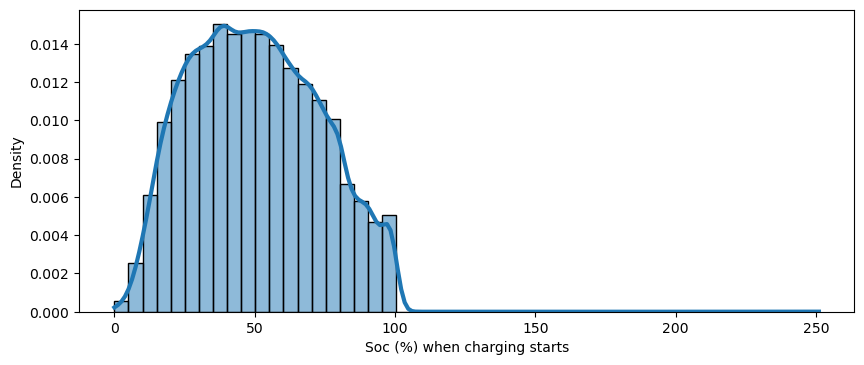

In [7]:
hist_kwargs = dict(stat ='density',
    bins= 50, 
    kde=True,
    color ='Tab:blue')
kde_args= {'lw':3, 'alpha':1, 'color':'red'}


fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(data_points, line_kws=kde_args,  **hist_kwargs)
plt.xlabel('Soc (%) when charging starts')


### Check points where SoC is above 100%


In [8]:
data_points[data_points>100]

array([251., 251.])

### Show Defaulting EVs


In [9]:
err_ev = []
for cur_ev in range(1,nb_evs+1): 
    if np.sum(soc_arr_df_dict[cur_ev]['State of charge'] >100) > 0:
        err_ev.append(cur_ev)

print('Defaulting Evs', err_ev)

Defaulting Evs [132, 149]


### Remove data points where Soc>100% and plot

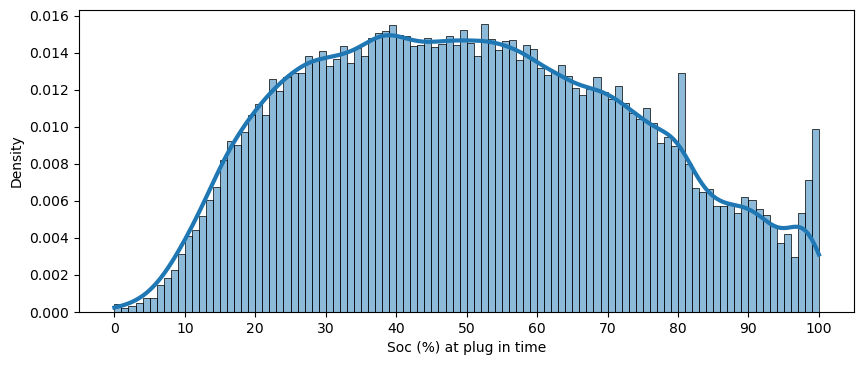

In [10]:
# Replace where soc >100 by nan
data_points[data_points>100] = np.nan

#Plot hist

hist_kwargs['bins'] = 100
fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
aa = sbn.histplot(data_points, line_kws=kde_args,  **hist_kwargs)
plt.xlabel('Soc (%) at plug in time')
plt.xticks((range(0,101,10)));

### Find Evs for which SoC at plug-in is above  $95\%$

In [11]:
# Find in Ev dataframe where the error is coming from
err_ev = []
for cur_ev in range(1,nb_evs): 
    if np.sum(soc_arr_df_dict[cur_ev]['State of charge'] >95) > 0:
        err_ev.append(cur_ev)

print('Defaulting Evs', err_ev)

Defaulting Evs [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183]


<a id = 'duplicates'></a>
### Check instants where Soc when charging starts $ > 95 \%$

In [12]:
Ev_number = 10, 100 # Select two Evs from previous output
for elm in Ev_number: 
    cur_ev_ArrSoc_df = soc_arr_df_dict[elm]
    print(f'***            Ev: ',elm,'          *******', )
    print(cur_ev_ArrSoc_df[cur_ev_ArrSoc_df['State of charge']>=95], '\n')


***            Ev:  10           *******
                     State of charge
Date                                
2012-05-03 15:35:00               97
2012-05-13 19:16:00              100
2012-05-13 19:16:00              100
2012-05-22 19:05:00              100
2012-05-22 19:05:00              100
2012-09-24 23:42:00               99
2012-09-24 23:42:00               99
2012-09-24 23:43:00               99
2012-10-16 03:15:00               98
2012-10-16 04:31:00               98
2013-02-14 22:34:00               98
2013-02-18 07:21:00               98
2013-03-26 21:13:00               98 

***            Ev:  100           *******
                     State of charge
Date                                
2012-01-15 23:29:00              100
2012-01-15 23:29:00               98
2012-01-30 23:09:00              100
2012-01-30 23:09:00              100
2012-01-30 23:09:00              100
2012-08-02 22:19:00              100
2012-08-02 22:19:00              100
2013-02-27 15:19:00        

### Remove duplicate and store new data in new dict

In [13]:
soc_arr_NoDup_df_dict = {} # Soc arrival no duplicate dataframe dict

for cur_ev_number in tqdm(range(1, nb_evs+1)):

    date = []
    index_soc = []
    cur_ev_ArrSoc_df = soc_arr_df_dict[cur_ev_number]

    # For each elm in cur_ev_ArrSoc_df save the element the first time it appears
    [(date.append(date_elm), index_soc.append(cur_ev_ArrSoc_df.iloc[int_index,0])) 
                         for int_index, date_elm in enumerate (cur_ev_ArrSoc_df.index) if date_elm not in date];
    # Explanation 
#     for int_index, date_elm in enumerate (cur_ev_ArrSoc_df.index): 
#         if date_elm not in date: 
#             date.append(date_elm)
#             index_soc.append(cur_ev_ArrSoc_df.iloc[int_index,0])

    
    new_df = pd.DataFrame(data=index_soc, index=date, columns=['State of charge']) # Create
    soc_arr_NoDup_df_dict.update({cur_ev_number: new_df})


100%|##########| 184/184 [00:02<00:00, 83.76it/s]


### Check if duplicates has been removed (compared with [here](#duplicates))

In [14]:
Ev_number = 10, 100
for elm in Ev_number: 
    cur_ev_ArrSoc_df = soc_arr_NoDup_df_dict[elm]
    print(f'***            Ev: ',elm,'          *******', )
    print(cur_ev_ArrSoc_df[cur_ev_ArrSoc_df['State of charge']>=95], '\n')


***            Ev:  10           *******
                     State of charge
2012-05-03 15:35:00               97
2012-05-13 19:16:00              100
2012-05-22 19:05:00              100
2012-09-24 23:42:00               99
2012-09-24 23:43:00               99
2012-10-16 03:15:00               98
2012-10-16 04:31:00               98
2013-02-14 22:34:00               98
2013-02-18 07:21:00               98
2013-03-26 21:13:00               98 

***            Ev:  100           *******
                     State of charge
2012-01-15 23:29:00              100
2012-01-30 23:09:00              100
2012-08-02 22:19:00              100
2013-02-27 15:19:00               97 



### Collect and plot filtered (no duplicates) data

In [15]:
new_list = []
for ev_number in tqdm(range(1, nb_evs+1)):
    new_list  = new_list + list(soc_arr_NoDup_df_dict[ev_number]['State of charge'].values)

100%|##########| 184/184 [00:00<00:00, 2555.50it/s]


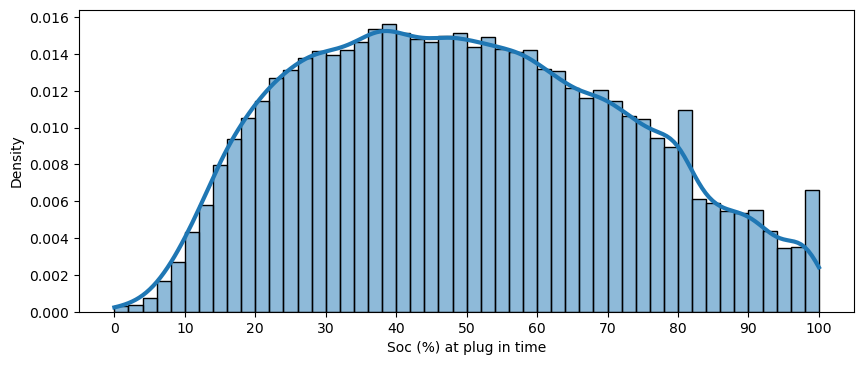

In [16]:
data_points = np.array(new_list)
# data_points[data_points>100] = np.nan

data_points = [elm for elm in data_points if elm <= 100]

hist_kwargs['bins'] = 50
fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(data_points, line_kws=kde_args,  **hist_kwargs)
plt.xlabel('Soc (%) at plug in time')
plt.xticks((range(0,101,10)));

### Fit Distribution to filtered Soc at plug-in time)

In [17]:
res = list_fitdistribution(data_points, distribution_list)

100%|##########| 48/48 [05:29<00:00,  6.86s/it]


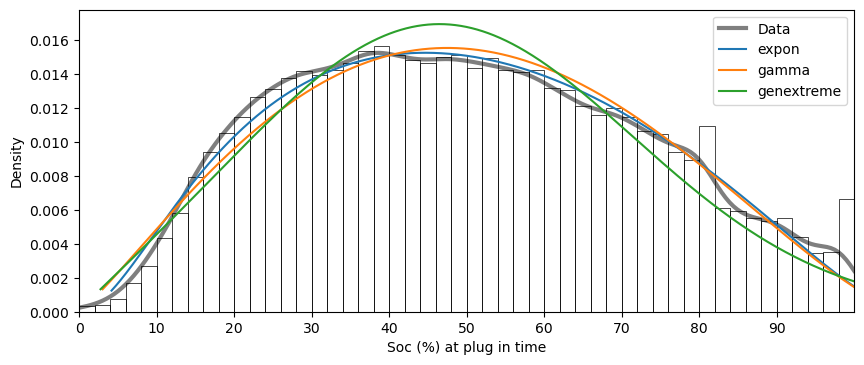

In [18]:
# Key words argument fot the histogram 
hist_kwargs["stat"] = 'density'
hist_kwargs["color"] = 'k'
hist_kwargs["lw"] = 0.5
hist_kwargs['fill']=False
kde_args= {'lw':3, 'alpha':0.5}

# Fit normal distribution
mean, var  = scipy.stats.distributions.norm.fit(data_points)
# Create a x_axis for data
x_space = np.linspace(0,100,1000)
fitted_data = scipy.stats.distributions.norm.pdf(x_space, mean, var)


fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(data_points,line_kws=kde_args,  **hist_kwargs)

plot_FittedDist(axx, ordered_dis_df(res),'Soc (%) at plug in time',3)

## Starting of charge time

In [19]:
#lambda function to convert df index in minute
# df_index[11:13] : Get hour of day
# df_index[14:16] : Get minutes of the current hour
conv_in_min = lambda df_index: int(df_index[11:13])*60 + int(df_index[14:16])

arr_times = [] # List to store arrival time in mn

for cur_ev in range(1,nb_evs):
    varr = soc_arr_NoDup_df_dict[cur_ev]# extract data of current ev
    
    #for each index in the resulting data frame, convert in minutes and save data
    [arr_times.append(conv_in_min(elm)) for elm in varr.index ]

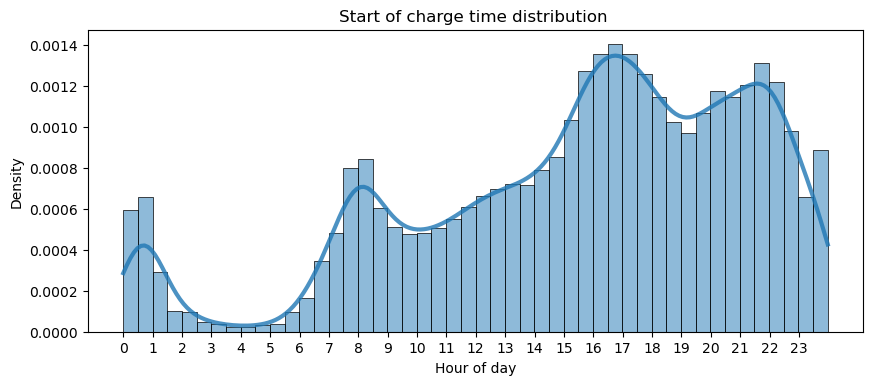

In [20]:
data_points = np.array(arr_times)# COnvert list in array

hist_kwargs['fill']=True
hist_kwargs['color']='Tab:blue'
hist_kwargs["lw"] = 0.5
hist_kwargs['bins'] = 48
kde_args= {'lw':3, 'alpha':0.8}

fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(data_points, line_kws=kde_args,  **hist_kwargs)
plt.xlabel('Hour of day')
axx.set(xticks = range(0, 1440,60), 
       xticklabels = range(0,24,1));
plt.title('Start of charge time distribution ');

# plt.xticks((range(0,101,10)));

### Fit Distribution to Starting of charge time distribution

In [ ]:
res = list_fitdistribution(data_points, distribution_list)

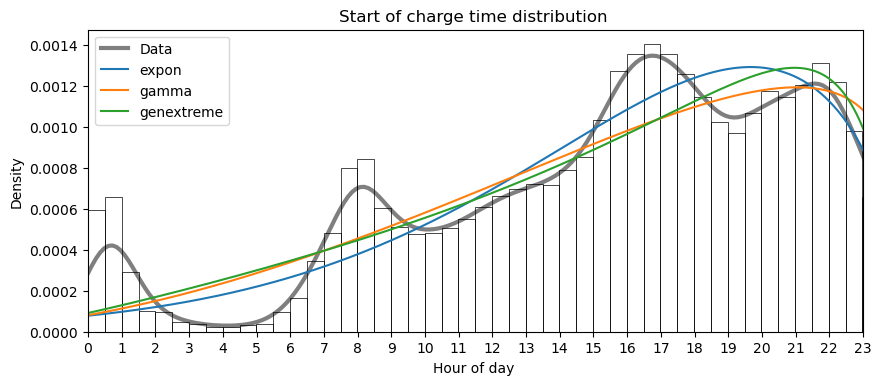

In [22]:
# parameters used in plotting funtions
nb_params = np.shape(pd.DataFrame(res))[1] - 2 # Get total number of parameters defined in res - 2 (distribution name and p-value)
param_list = ['param'+str(i) for i in range(nb_params)]

# Key words argument for the histogram 
hist_kwargs["stat"] = 'density'
hist_kwargs["color"] = 'k'
hist_kwargs["lw"] = 0.5
hist_kwargs['fill']=False
kde_args= {'lw':3, 'alpha':0.5}


fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(data_points,line_kws=kde_args,  **hist_kwargs)
plot_FittedDist(axx, ordered_dis_df(res),'Hour of day ',3)
axx.set(xticks = range(0, 1440,60), 
       xticklabels = range(0,24,1));
plt.title('Start of charge time distribution ');


# Charging Duration

### Extract data

In [23]:
# List to store length of period of charge
charging_per = []

for cur_ev in tqdm (range(1,nb_evs+1)): # For each EV in the dataset or folder
    
    fname_soc = folder_soc+ 'EV_' +str(cur_ev)+ '_SoC.csv' # Define name of file to load
    cur_ev_soc = pd.read_csv(fname_soc,index_col=['Date']) # read the file,  using the column date as index
    cur_ev_soc.index = pd.to_datetime(cur_ev_soc.index)    # convert index from string to datetime

    for iindex in range(1, len(cur_ev_soc) ): # For each saved SOC 
        # compute diff between the soc of the current and the previous instant
        soc_diff = cur_ev_soc.iloc[iindex] - cur_ev_soc.iloc[iindex-1]

        if  (soc_diff['State of charge'] > 0) : # if diff > 0  Charging occured between the current and 
                                                # the previous instant
            # Compute period of charging 
            period_diff = cur_ev_soc.index[iindex] - cur_ev_soc.index[iindex-1]
            
            if (period_diff < timedelta(days=1)) == True : # Consider only lenght of charge less than a day
                charging_per.append(period_diff.total_seconds()//60) # COnvert period in minutes and store it 




100%|##########| 184/184 [05:19<00:00,  1.74s/it]


### Plot charging duration data

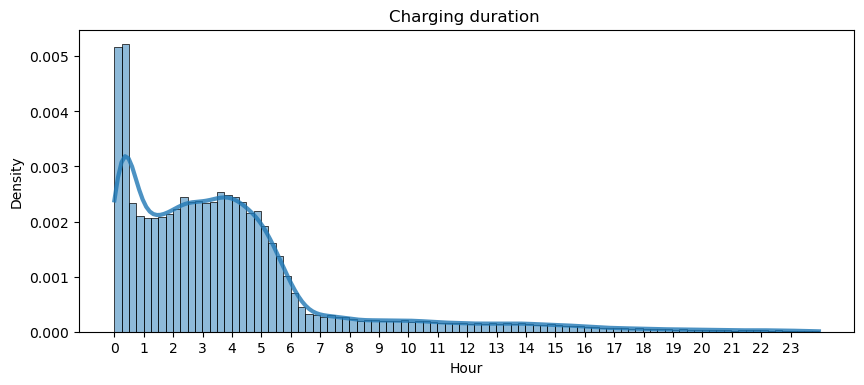

In [24]:
data_points = np.array(charging_per)# COnvert list in array

hist_kwargs['fill']=True
hist_kwargs['color']='Tab:blue'
hist_kwargs["lw"] = 0.5
hist_kwargs['bins'] = 96
kde_args= {'lw':3, 'alpha':0.8}

fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(data_points,  line_kws=kde_args,  **hist_kwargs)
plt.xlabel('Hour')
axx.set(xticks = range(0, 1440,60), 
       xticklabels = range(0,24,1));
plt.title('Charging duration ');

# plt.xticks((range(0,101,10)));

### Fit Distribution to previous data_set

In [25]:
res = list_fitdistribution(data_points, distribution_list)

 96%|#########5| 46/48 [05:16<00:02,  1.41s/it]C:\Users\jprince\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|##########| 48/48 [05:19<00:00,  6.65s/it]


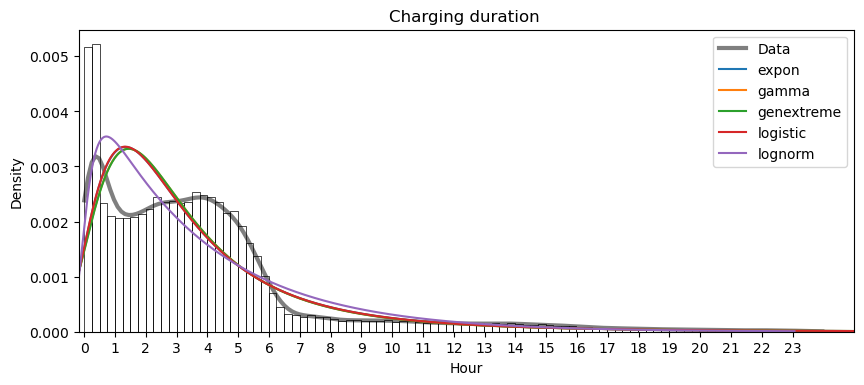

In [26]:
# Key words argument fot the histogram 
hist_kwargs["stat"] = 'density'
hist_kwargs["color"] = 'k'
hist_kwargs["lw"] = 0.5
hist_kwargs['fill']=False
kde_args= {'lw':3, 'alpha':0.5}



fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(data_points,line_kws=kde_args,  **hist_kwargs)
plot_FittedDist(axx, ordered_dis_df(res),'Soc (%) at plug in time',5)
plt.xlabel('Hour')
axx.set(xticks = range(0, 1440,60), 
       xticklabels = range(0,24,1));
plt.title('Charging duration ');
plt.xlim((-10, 1500));

<div class="alert alert-block alert-info">
<b>TODO:</b> Use Mixed of distribution to get a better fit for wrongly fitted data.
</div>